# **Mini Project Week 3: CNN Cancer Detection Kaggle Competition**

## Introduction and Problem Description

The following code is part of the Week 3's assignment/mini project of the Coursera course Introduction to Deep Learning with the focus on studying and applying Convolutional Neural Networks. The following sections will describe the process I followed while doing this work.

Data was taken from Kaggle's competition shown in [HERE](http:/https://www.kaggle.com/c/histopathologic-cancer-detection//)

## Problem Description

The data shared on Kaggle's website contain various pictures showing pathology scans that may have cancerous cells or tissues within them. The objective of the competition is to generate a model that has the capability of identifying cases with cancerous cells present in the tissue. As an aid to the model's training process, the pictures showing cancerous tissues were labeled with a "1".


### Import of Libraries used for the project
The first part is to load all the libraries and packages needed for the development of the model

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## Exploratory Data Analysis (EDA)

The second step is to read the data provided and understand it by performing a quick exploratory data analysis.

The code shown below will provide number of columns and its label, following by if there are empty cells and its data type. In addition to it, I plotted the distribution for positive and negative cases to have a better idea of the data that will be used for training and test purposes.

In [13]:
full_data_df = pd.read_csv('C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/train_labels.csv', dtype=str)
full_data_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 220025 entries, 0 to 220024

Data columns (total 2 columns):

 #   Column  Non-Null Count   Dtype 

---  ------  --------------   ----- 

 0   id      220025 non-null  object

 1   label   220025 non-null  object

dtypes: object(2)

memory usage: 3.4+ MB


% Positive Cases: 0    59.5

1    40.5

Name: label, dtype: float64

% Nevative Cases: 0    40.5

1    59.5

Name: label, dtype: float64


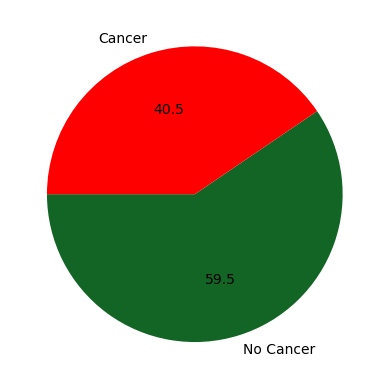

<Figure size 1600x1600 with 0 Axes>

In [17]:
positive_cases = round(full_data_df['label'].value_counts()/len(full_data_df['label'])*100, 2)
negative_cases = 100 - positive_cases
print('% Positive Cases:',positive_cases)
print('% Nevative Cases:',negative_cases)

labels_data = full_data_df.label.value_counts()
plt.pie(labels_data, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#126524','#FF0000'], shadow=False)
plt.figure(figsize=(16,16))
plt.show()

There are in total 220,025 values. With the pie chart, we can see that 60% of the data are negative or without cancer and the remaining 40% represent positive cases. 

Then, I wrote the following code to understand the properties of the pictures that will be used.

Sample Img


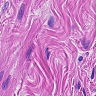

Image size: (96, 96)

Image as array shape: (96, 96, 3)


In [22]:
full_data_df.id = full_data_df.id + '.tif'

# Extracting a file to identify the structure
sample_file = df['id'][8]
picture = Image.open(f'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/train/{sample_file}')

print('Sample Img')
display(picture)
print('Image size:',picture.size)

# Converting in to an array
array_picture = np.array(picture)
print('Image as array shape:',array_picture.shape)
# print(imarray)

Each of the pictures contained in the folders are identified by a label called "id". The images have a size of 96x96 pixels. The code is also converting the pictures into RGB arrays for further processing.

## Model Architecture Description

After doing some research of the different architectures that exist for CNN,I found a lot of documentation related with "Transfer Learning", specifically with VGG16 in [HERE](https://keras.io/guides/transfer_learning/) so I decided to go with it. 

I start first by setting up the model, splitting the data given into two sets : "train" and "test". I left most of the values as "default" after following the documentation on Keras website and considering the limitations of my CPU. 

In summary, the train dataset has 165,018 images and the test dataset 55,007 images.

In [23]:
train, test = train_test_split(df, stratify=df.label)
gen = ImageDataGenerator(rescale=1/255)

train_set = gen.flow_from_dataframe(
    dataframe = train,
    directory = 'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/train',
    x_col = 'id',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (96, 96)
)

test_set = gen.flow_from_dataframe(
    dataframe = test,
    directory = 'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/train',
    x_col = 'id',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (96, 96)
)

Found 165018 validated image filenames belonging to 2 classes.

Found 55007 validated image filenames belonging to 2 classes.


The following lines of code configure the VGG16 model. Once its done, I print out a summary to see its architecture and its hyperparameters (values that I would change through the course of the development to try to get better results).

In [24]:
#Following tutorial from https://keras.io/guides/transfer_learning/
base_model = tf.keras.applications.VGG16(
    input_shape=(96,96,3), 
    include_top=False, 
    weights='imagenet')

base_model.trainable = False

base_model.summary()

Model: "vgg16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         

                                                                 

 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         

                                                                 

 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 24, 24, 1

With the following code, I modify as desired the layers and other properties of the model. I did several experiments trying more layers and changing "Dense" and "Dropout" values to see which one could give me better accuracy.In the end, my model had 4 layers, activated with 3 Relu functions and 1 softmax. I went with this strategy considering the nature of the problem - simple binary classification ( "with cancer" , "w/o cancer").

In [25]:
CNN_project = tf.keras.models.Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(20, activation='relu'),
    Dropout(0.8),
    Dense(14, activation='relu'),
    Dropout(0.7),
    Dense(6, activation='relu'),
    Dropout(0.6),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

CNN_project.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 3, 3, 512)         14714688  

                                                                 

 batch_normalization_2 (Batc  (None, 3, 3, 512)        2048      

 hNormalization)                                                 

                                                                 

 flatten_1 (Flatten)         (None, 4608)              0         

                                                                 

 dense_3 (Dense)             (None, 20)                92180     

                                                                 

 dropout_2 (Dropout)         (None, 20)                0         

                                                                 

 dense_4 (Dense)             (None, 14)                294       

                                      

Once the model is set up, we get to the training process. Originally, I was accounting for a training with 8 epochs, but I had to reduce it several times because it was taking too much time (I'm running this project on a CPU, not GPU).

In [31]:
%%time 
improvement = tf.keras.optimizers.Adam(0.001)
CNN_project.compile(loss='categorical_crossentropy', optimizer=improvement, metrics=['accuracy', tf.keras.metrics.AUC()])

First_Test = CNN_project.fit(
    x = train_set, 
    steps_per_epoch= len(train_set), 
    epochs = 2,
    validation_data = test_set, 
    validation_steps = len(test_set), 
    verbose = 'auto'
)

Epoch 1/2

5157/5157 [==============================] - 17147s 3s/step - loss: 0.5640 - accuracy: 0.7351 - auc_8: 0.7863 - val_loss: 0.4769 - val_accuracy: 0.7998 - val_auc_8: 0.8875

Epoch 2/2

5157/5157 [==============================] - 17270s 3s/step - loss: 0.5319 - accuracy: 0.7602 - auc_8: 0.8191 - val_loss: 0.4350 - val_accuracy: 0.8261 - val_auc_8: 0.9054

Wall time: 9h 33min 42s


After the training finished, the model ended with an acurracy of 0.7602 (I'll talk more about it in the Conclusion section). Once trained, I proceeded to test it.

In [32]:
test_data = pd.read_csv('C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/sample_submission.csv')
test_data['filename'] = test_data.id + '.tif'

In [33]:
batch_1 = generator.flow_from_dataframe(
    dataframe = test_data,
    directory = 'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/test',
    x_col = 'filename',
    batch_size = 10,
    shuffle = False,
    class_mode = None,
    target_size = (96, 96)
)

Found 57458 validated image filenames.


In [34]:
pred_CNN=CNN_project.predict(batch_1)

5746/5746 [==============================] - 4540s 789ms/step


In [35]:
pred_value = np.argmax(pred_CNN, axis =1)

Finally, I made a prediction using probabilities of having positive cases ("1") or negative cases ("0"). Therefore, I used "argmax" to get the maximum value.

The last lines shown below export the results to a csv file as a requisite of Kaggel's competition.

In [37]:
df_test2 = pd.read_csv('C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW3/sample_submission.csv')
df_test2.label = pred_value
df_test2.shape
                       

(57458, 2)

In [39]:
df_test2.to_csv('final_submission.csv', header = True, index = False)

## Results and Analysis

The model delivered an accuracy of 0.76 considering the parameters used above. 

I believe that transfer learning is useful for this sort of analysis. Furthermore, I could have gotten better results if I kept looking for the right combination of hyperparameters and the appropriate hardware. However, considering the short period of time to deliver this work and from an eduactional standpoint of view, I consider the results as appropriate.


## Conclusion

This project was my very first interaction with neural network programming and all the science behind it. 

I based my results on probabilities in this particular case in which the model needed to determine if it was cancerous tissue or not. However, I'm aware that this model wouldn' work correctly if there were more categories or labels involved.

Finally,I was able to understand the huge power that machine learning has through this real-life application. My next steps in my Data Science journey are to keep investigating for more models and better algorithms for different kind of problems.